## Sistem Rekomendasi Alat Musik dengan Collaborative Filtering dan K-Nearest Neighbor

Nama Ketua             : Aliza Hanum Anggani / 123170090 ( A )

Nama Anggota           : Alfriska Deviane Puspita / 123170108 ( A )

Sumber Dataset : https://www.kaggle.com/eswarchandt/amazon-music-reviews

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import surprise
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise import Reader, Dataset
from surprise import KNNBasic

In [2]:
dataset_music = pd.read_csv("Musical_instruments_reviews.csv")
dataset_music.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
dataset_music.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


In [4]:
dataset_music.shape

(10261, 9)

In [5]:
dataset_music.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [6]:
print('Rating terendah: %d' %(dataset_music.overall.min()))
print('Rating tertinggi: %d' %(dataset_music.overall.max()))

Rating terendah: 1
Rating tertinggi: 5


In [7]:
print("\nJumlah Total Rating :",dataset_music.shape[0])
print("Jumlah Total Pengguna   :", len(np.unique(dataset_music.reviewerID)))
print("Jumlah Total Produk  :", len(np.unique(dataset_music.asin)))


Jumlah Total Rating : 10261
Jumlah Total Pengguna   : 1429
Jumlah Total Produk  : 900


In [8]:
count_user_rate = dataset_music.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

count_user_rate

reviewerID
ADH0O8UVJOT10     42
A15TYOEWBQYF0X    38
A1L7M2JXN4EZCR    38
A2EZWZ8MBEDOLN    36
A2NYK9KWFMJV4Y    34
                  ..
A9KOC3PXLXYSB      5
A25T143MKB0K82     5
A9AETC0WEPZAM      5
A256QA9N8ZK520     5
A2Z15UQEUTE3T9     5
Name: overall, Length: 1429, dtype: int64

asin
B003VWJ2K8    163
B0002E1G5C    143
B0002F7K7Y    116
B003VWKPHC    114
B0002H0A3S     93
             ... 
B000Y60NFC      5
B000Y7Q2C4      5
B0010CHS8E      5
B0010KCP98      5
1384719342      5
Name: reviewerID, Length: 900, dtype: int64

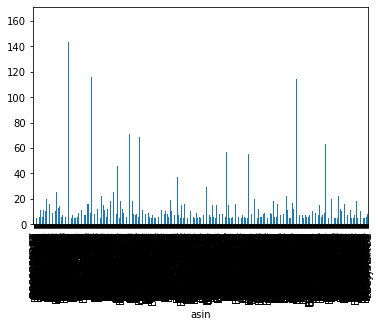

In [9]:
dataset_music.groupby('asin').count()['reviewerID'].plot.bar()
asin_reviewerID = dataset_music.groupby('asin').count()['reviewerID'].sort_values(ascending=False)
asin_reviewerID

In [10]:
rating_user = dataset_music.groupby(by='asin')['overall'].count().sort_values(ascending=False)

rating_user

asin
B003VWJ2K8    163
B0002E1G5C    143
B0002F7K7Y    116
B003VWKPHC    114
B0002H0A3S     93
             ... 
B000Y60NFC      5
B000Y7Q2C4      5
B0010CHS8E      5
B0010KCP98      5
1384719342      5
Name: overall, Length: 900, dtype: int64

<AxesSubplot:xlabel='asin'>

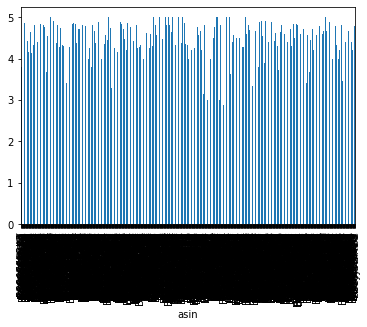

In [11]:
dataset_music.groupby('asin').mean()['overall'].plot.bar()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


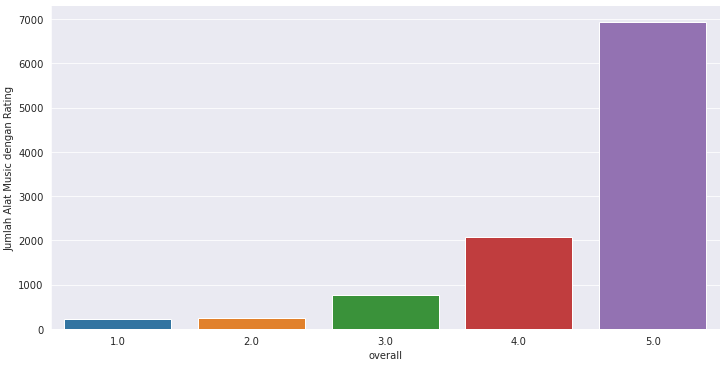

In [12]:
with sns.axes_style('darkgrid'):
    g = sns.factorplot("overall", data=dataset_music, aspect=2.0,kind='count')
    g.set_ylabels("Jumlah Alat Music dengan Rating")

In [13]:
new_dataset_music =dataset_music.groupby("asin").filter(lambda x:x['overall'].count() >=20)
new_dataset_music.groupby('asin')['overall'].mean().sort_values(ascending=False).describe()

count    91.000000
mean      4.549162
std       0.229394
min       3.807692
25%       4.454762
50%       4.560000
75%       4.709375
max       5.000000
Name: overall, dtype: float64

In [14]:
new_dataset_music.shape

(3577, 9)

In [15]:
ratings_mean_count = pd.DataFrame(new_dataset_music.groupby('asin')['overall'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_dataset_music.groupby('asin')['overall'].count())
ratings_mean_count.head()

,overall,rating_counts
asin,,
B000068NW5,4.461538,52
B0002CZSJO,4.607143,28
B0002CZSJY,4.636364,22
B0002CZUUG,4.545455,22
B0002CZV82,4.050000,20


In [33]:
ratings_mean_count

,overall,rating_counts
asin,,
B000068NW5,4.461538,52
B0002CZSJO,4.607143,28
B0002CZSJY,4.636364,22
B0002CZUUG,4.545455,22
B0002CZV82,4.050000,20
...,...,...
B0073XCXHA,4.818182,22
B008BPI2HE,4.657143,35
B00AZUAORE,4.583333,24


In [31]:
print('Minimum rating count: %d' %(ratings_mean_count.rating_counts.min()))
print('Maximum rating count: %d' %(ratings_mean_count.rating_counts.max()))

Minimum rating count: 20
Maximum rating count: 163


In [17]:
new_dataset_music.drop(['unixReviewTime'], axis=1,inplace=True)
new_dataset_music.drop(['helpful'], axis=1,inplace=True)
new_dataset_music.drop(['reviewText'], axis=1,inplace=True)
new_dataset_music.drop(['reviewTime'], axis=1,inplace=True)
new_dataset_music.drop(['reviewerName'], axis=1,inplace=True)
new_dataset_music.drop(['summary'], axis=1,inplace=True)
new_dataset_music.head()

,reviewerID,asin,overall
41,AA5TINW2RJ195,B000068NW5,5.0
42,ABC68JUCPTVOE,B000068NW5,5.0
43,A3W2E6S24BTXXK,B000068NW5,5.0
44,A3872Y2XH0YDX1,B000068NW5,5.0
45,A398X9POBHK69N,B000068NW5,4.0


In [34]:
new_dataset_music

,reviewerID,asin,overall
41,AA5TINW2RJ195,B000068NW5,5.0
42,ABC68JUCPTVOE,B000068NW5,5.0
43,A3W2E6S24BTXXK,B000068NW5,5.0
44,A3872Y2XH0YDX1,B000068NW5,5.0
45,A398X9POBHK69N,B000068NW5,4.0
...,...,...,...
10235,A27L5L6I7OSV5B,B00IZCSW3M,5.0
10236,AOMEH9W6LHC4S,B00IZCSW3M,5.0
10237,A3VDSGNIS92OVZ,B00IZCSW3M,3.0
10238,A27H0T39U3FZB5,B00IZCSW3M,5.0


In [73]:
reader = Reader(rating_scale=(1, 5))
data_n = Dataset.load_from_df(new_dataset_music, reader)
trainset, testset = train_test_split(data_n, test_size=0.3,random_state=10)

In [90]:
from surprise import KNNWithMeans
algo = KNNWithMeans(k=5, sim_options={'name':'pearson', 'user_based': True})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [91]:
test_pred = algo.test(testset)
test_pred

[Prediction(uid='A15TYOEWBQYF0X', iid='B003VWJ2K8', r_ui=1.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A19WXFFQMKES6O', iid='B000EELB8W', r_ui=5.0, est=3.166666666666667, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A1YP96MT6W9FTB', iid='B008BPI2HE', r_ui=5.0, est=4.25, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1V3N0LF1QGG0X', iid='B000RNB720', r_ui=2.0, est=4.55852976428286, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A15BHBF0L0HV1F', iid='B000068NW5', r_ui=5.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3PGQWCSJPCYDH', iid='B0002GJ6FC', r_ui=3.0, est=3.1666666666666665, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AHF7SNSZPRNCE', iid='B004XNK7AI', r_ui=3.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1DZDG9AT98298', iid='B0009G1E0K', r_ui=4.0, est=5, details={'act

In [92]:
accuracy.mae(test_pred)
accuracy.rmse(test_pred)

MAE:  0.6080
RMSE: 1.0034


1.0034444027826706

In [22]:
pred_df = pd.DataFrame(test_pred)
pred_df.columns =['reviewerID', 'asin', 'est','overall','Details']
pred_df

,reviewerID,asin,est,overall,Details
0,A2JMJVNTBL7K7E,B0002E3CHC,3.0,4.444444,"{'actual_k': 0, 'was_impossible': False}"
1,AJBBU53A0X84I,B0002D0E8S,5.0,4.631579,"{'actual_k': 0, 'was_impossible': False}"
2,A14CQY582WMP7O,B0002E2KPC,5.0,4.488372,"{'actual_k': 0, 'was_impossible': False}"
3,A3H4S6YO9VNGDZ,B000978D58,3.0,4.472222,"{'actual_k': 0, 'was_impossible': False}"
4,A30KA8I5AHSKJZ,B001W99HE8,5.0,4.557782,"{'was_impossible': True, 'reason': 'User and/o..."
...,...,...,...,...,...
1426,A1H4EBBOM66MQ0,B00646MZHK,5.0,4.575000,"{'actual_k': 0, 'was_impossible': False}"
1427,A1SD1C8XK3Z3V1,B0002GZM00,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}"
1428,A3R6V43G6HAJ0Y,B0002E1G5C,4.0,5.000000,"{'actual_k': 1, 'was_impossible': False}"
1429,A3HKWOC783B7PL,B004Z17008,5.0,4.557782,"{'was_impossible': True, 'reason': 'User and/o..."


In [23]:
w = pred_df.Details[0]
new_data = pd.DataFrame(pred_df[(pred_df['Details']!=w)])
new_data.drop(['Details'], axis=1,inplace=True)

In [24]:
new_data

,reviewerID,asin,est,overall
4,A30KA8I5AHSKJZ,B001W99HE8,5.0,4.557782
7,AKGWRO6IC0VIE,B000B6DHB2,1.0,4.557782
10,A10FM4ILBIMJJ7,B003VWJ2K8,4.0,5.000000
13,A46D3MTB5LIUY,B0002H0A3S,5.0,4.557782
15,A3DJUUPM321IFI,B0006NDF8A,4.0,4.557782
...,...,...,...,...
1424,AO7WPPUO75BBK,B0002GMGYA,5.0,3.139929
1427,A1SD1C8XK3Z3V1,B0002GZM00,5.0,5.000000
1428,A3R6V43G6HAJ0Y,B0002E1G5C,4.0,5.000000
1429,A3HKWOC783B7PL,B004Z17008,5.0,4.557782


In [25]:
new_data.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

reviewerID
A46D3MTB5LIUY     6
A2Z89YMZZJWBHS    4
A149F91FB9WTW6    4
A1S7QABO64Z554    4
A24FQKYEPUQBRG    3
                 ..
A3AOPVQ7EZHTWA    1
A3B4L653KYTW55    1
A3BZ9EP6SSC9MU    1
A3DJUUPM321IFI    1
A109ME7C09HM2M    1
Name: overall, Length: 368, dtype: int64

In [26]:
i = 'B0002CZW0Y'
tsr_inner_id = algo.trainset.to_inner_iid(i)
tsr_neighbors = algo.get_neighbors(tsr_inner_id, k=4)
product = new_dataset_music[['asin']].drop_duplicates(['asin'])
product[product.asin.isin([algo.trainset.to_raw_iid(inner_id)
                       for inner_id in tsr_neighbors])]

,asin
3222,B0002M3OVI
3880,B000978D58
5676,B000ULAP4U
9345,B005OZE9SA


In [27]:
def rekomendasi_produk(idpengguna):
    y = new_data[(new_data['est']>3.0)&(pred_df['reviewerID']==idpengguna)].head(10)
    return y[['asin','est']]

In [28]:
print("Rekomendasi Produk Untuk Pengguna : ")
rekomendasi_produk("A2IBPI20UZIR0U")

Rekomendasi Produk Untuk Pengguna : 


<ipython-input-27-fc7a7192152c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = new_data[(new_data['est']>3.0)&(pred_df['reviewerID']==idpengguna)].head(10)


,asin,est


In [29]:
def rekomendasi_User(productid):
    y = new_data[(new_data['est']>3.0)&(pred_df['asin']==productid)].head(10)
    return y[['reviewerID','est']]

In [30]:
print("Pengguna lain yang mendapatkan rekomendasi produk :" )
rekomendasi_User(i)

Pengguna lain yang mendapatkan rekomendasi produk :


<ipython-input-29-68292ea6d4a7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = new_data[(new_data['est']>3.0)&(pred_df['asin']==productid)].head(10)


,reviewerID,est
200,A39JMLMY96E8CP,5.0
240,A1UMM894XSEO4F,4.0
328,A3E7O9NSS47TE8,4.0
495,A1L7M2JXN4EZCR,5.0
791,A1K45HFFFDNP1A,4.0
1110,AH4HBHRM707WA,4.0
1293,A3EU3ET85O8ZFX,5.0
1382,A2WYF4POBUXL2O,4.0
